# Chapter 3 – Fiction: Growing Down in the Novels of Maria Edgeworth and Amelia Opie

According to most scholars, the *Bildungsroman* is the central genre of Romantic fiction. The *Bildungsroman*, at least in its ‘classical’ or Romantic form, is the novel of successful self-formation. The protagonist of the Bildungsroman goes out in the world, develops their personality, and finally settles down. Scholars have constructed a canon around a core of optimistic novels—*Wilhelm Meister’s Apprenticeship* (1795-96), *Pride and Prejudice* (1813), *Waverley* (1814)—whose protagonists successfully go out into the world and find a place within it. In such *Bildungsromane*, the protagonist is both free and constrained. They pursue their inclinations while fulfilling their duties. They express their individuality while conforming to the social order. They achieve a ‘balance of harmony with freedom’, as Karl Morgenstern put it in a classic essay from 1820.

In this Chapter, I consider two novels that contradict the concept of the *Bildungsroman*. In Amelia Opie’s *Adeline Mowbray* (1804) and Maria Edgeworth’s *Vivian* (1812), there is no balance between individuality and the social order, between freedom and harmony, between autonomy and authority. To show that these novels were not mere outliers in the period, I analyse them as part of a corpus of 40 novels from the period, including a mixture of classic *Bildungsromane* such as *Camilla* (1796), *Marriage* (1818) and *The Old Manor House* (1793), American network novels such as *Arthur Mervyn* (1799), *The Coquette* (1797) and *Hobomok* (1824), as well as a number of Gothic, Jacobin, Anti-Jacobin, Historical and National Novels. The [files](data/novel-corpus/) and [metadata](data/novel-corpus/manifest.json) can be found in this repository, with the exception of 5 files, identified in the metadata, which are under copyright.

In this Notebook, I generate the tables and figures that can be found in Chapter 3 of *Contingent Selves: Romanticism and the Challenge of Representation*.

In [1]:
from collections import Counter
from itertools import zip_longest, chain
import re

from romanticself import *
from nltk import wordpunct_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import igraph as ig
import nltk
from openpyxl import Workbook

In [2]:
# For tokenizers
nltk.download('punkt')
nltk.download('tagsets')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelgfalk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/michaelgfalk/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelgfalk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/michaelgfalk/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
corpus = NovelCorpus("data/novel-corpus", tokenizer=word_tokenize)

40 novels imported from data/novel-corpus.


## 3.1: Character: Unnecessary Beings

### Table 3.1 Self-control was a central theme in Romantic fiction

In [4]:
def count_compound_words(corpus, stem, relative=True):
    """Count relative frequencies of words beginning with given stem in corpus.
    
    Arguments:
    - corpus (iterable): iterable of tokenised texts
    - stem (str): words must begin with this stem to be counted
    - relative (bool): divide frequencies by word length of each text?"""

    compound_words = []

    for novel in tqdm(corpus, total=len(corpus)):
        counts = Counter()
        for word in novel:
            if word.startswith(stem):
                counts[word] += 1

        if relative == True:
            wc = len(novel)
            counts = {word:(count/wc * 1000) for word,count in counts.items()}

        compound_words.append(counts)
    
    data_frame = pd.DataFrame.from_dict(compound_words)
    data_frame["title"] = [title[0] for title in corpus.yield_metadata("short_title")]
    data_frame.set_index("title", inplace=True)
    data_frame.fillna(0, inplace=True)

    return data_frame

In [5]:
self_compounds = count_compound_words(corpus, stem="self-")

  0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
def compound_words_output(compound_words, topn=20, to_excel: str | bool=False, novels=list()):
    """Extracts readable output of compound_words function.
    
    Arguments:
    - compound_words (pd.DataFrame): output of count_compound_words
    - topn (int): maximum number of words to show in table
    - tocsv (str): csv to save results to. Pass False to avoid
    - novels (iterable): titles of the novels to be included in output"""

    results = dict()
    
    # Results for each novel
    for novel in novels:
        # Get frequencies for that novel
        novel_result = compound_words.loc[novel].sort_values(ascending=False)
        # Filter out compounds that don't appear
        novel_result = novel_result[novel_result > 0]
        # Convert to list and append
        results[novel] = list(zip(novel_result.index, novel_result))

    # Corpus statistics
    corpus_means = compound_words.mean().sort_values(ascending=False)[:topn]
    results["Corpus"] = list(zip(corpus_means.index,corpus_means))
    
    # Save
    if isinstance(to_excel, str):
        workbook = Workbook()
        sheet = workbook.active
        first_row = [*chain.from_iterable((title,"value") for title in results)]
        sheet.append(first_row)
        for row in zip_longest(*results.values(), fillvalue=('','')):
            row_list = [*chain.from_iterable(row)]
            sheet.append(row_list)
        workbook.save(to_excel)

    return results

In [7]:
table_3_1_data = compound_words_output(compound_words=self_compounds, topn=20, to_excel="figures/table_3_1.xlsx", 
                                        novels=["Vivian", "Adeline Mowbray"])

In [8]:
table_3_1_data["Vivian"]

[('self-love', 0.034636832808008035),
 ('self-willed', 0.023091221872005355),
 ('self-reproach', 0.023091221872005355),
 ('self-esteem', 0.023091221872005355),
 ('self-possession', 0.023091221872005355),
 ('self-confidence', 0.011545610936002678),
 ('self-complacency', 0.011545610936002678),
 ('self-interest', 0.011545610936002678),
 ('self-condemned', 0.011545610936002678),
 ('self-delusion', 0.011545610936002678),
 ('self-command', 0.011545610936002678)]

In [9]:
table_3_1_data["Adeline Mowbray"]

[('self-love', 0.11361376998892267),
 ('self-command', 0.07574251332594843),
 ('self-denial', 0.04733907082871777),
 ('self-condemned', 0.028403442497230667),
 ('self-reproach', 0.028403442497230667),
 ('self-upbraidings', 0.028403442497230667),
 ('self-reproaches', 0.028403442497230667),
 ('self-congratulations', 0.018935628331487108),
 ('self-condemnation', 0.018935628331487108),
 ('self-possession', 0.009467814165743554),
 ('self-denials', 0.009467814165743554),
 ('self-conceit', 0.009467814165743554),
 ('self-upbraiding', 0.009467814165743554),
 ('self-abasement', 0.009467814165743554)]

In [10]:
table_3_1_data["Corpus"]

[('self-love', 0.010329982810622279),
 ('self-command', 0.009571589057540682),
 ('self-denial', 0.009155261736731804),
 ('self-reproach', 0.007151002072696255),
 ('self-possession', 0.006056117143863439),
 ('self-complacency', 0.0025995896685862712),
 ('self-will', 0.002595884438243359),
 ('self-willed', 0.002586800861606716),
 ('self-approbation', 0.0025494232784229417),
 ('self-denying', 0.0025322301781799295),
 ('self-respect', 0.0024264560544763414),
 ('self-interest', 0.0024258726522881405),
 ('self-conceit', 0.0022107510203603358),
 ('self-condemnation', 0.0021953228381445334),
 ('self-preservation', 0.0019320828100202595),
 ('self-reproaches', 0.0018302385216697067),
 ('self-importance', 0.001824960140229312),
 ('self-satisfied', 0.0017983370404249701),
 ('self-examination', 0.0017818950648328818),
 ('self-satisfaction', 0.0015203146674683614)]

In [11]:
# How many novels use the term 'self-denial'?
self_compounds.astype(bool).sum(axis=0).sort_values(ascending=False)[:20]

self-denial          18
self-reproach        15
self-love            15
self-command         15
self-approbation     11
self-possession      11
self-interest        10
self-delusion         8
self-willed           8
self-satisfied        8
self-denying          8
self-complacency      8
self-conceit          7
self-preservation     7
self-defence          7
self-importance       7
self-condemnation     7
self-satisfaction     7
self-reproaches       6
self-examination      6
dtype: int64

### Table 3.2 *Vivian* and *Adeline Mowbray* are particularly focussed on the self

In [12]:
per_novel_totals = self_compounds.sum(axis=1).sort_values(ascending=False)
# Export csv for Figure 3.2
per_novel_totals.to_excel("figures/table_3_2.xlsx")
# And print the data to the screen
per_novel_totals

title
Self-Control                                                 0.496183
Adeline Mowbray                                              0.435519
Camilla                                                      0.268043
Walsingham                                                   0.216192
Marriage                                                     0.211328
The Cottagers of Glenburnie                                  0.204400
Vivian                                                       0.196275
The Last of the Mohicans                                     0.188307
Memoirs of Emma Courtney                                     0.184533
Anna St. Ives                                                0.169354
Zofloya                                                      0.162507
Caleb Williams                                               0.157362
Persuasion                                                   0.156021
Maria                                                        0.155649
The Recess    

In [13]:
# What is the average use of 'self-' compounds across the corpus?
per_novel_totals.mean()

0.12883350489918538

In [14]:
# Do network novels use 'self-' compounds much?
network = [net[0] for net in corpus.yield_metadata("network")]

network_mean = self_compounds.sum(axis=1)[network].mean()
non_network_mean = self_compounds.sum(axis=1)[[not val for val in network]].mean()

print(f"Network novels' usage of compounds with 'self': {network_mean:.3f}")
print(f"Other novels' usage of compounds with 'self': {non_network_mean:.3f}")

Network novels' usage of compounds with 'self': 0.047
Other novels' usage of compounds with 'self': 0.141


## 3.2: Plot: Marriage Disrupted

### Table 3.3 Unsanctioned 'connexions'

In [15]:
def count_words(corpus, words):
    """Counts words in corpus, returns data frame of relative frequencies.
    
    Arguments:
    - corpus (NovelCorpus): A romanticself.NovelCorpus
    - words (iterable): Iterable of words to count
    
    Returns:
    - counts (pd.DataFrame): Data frame of relative word counts for selected words"""
    
    word_counts = [len(text) for text in corpus]
    titles = [val[0] for val in corpus.yield_metadata("short_title")]
    data = {}
    
    for novel,title,wc in zip(corpus,titles,word_counts):
        data[title] = {word:novel.count(word)/wc*1000 for word in words}
    
    return pd.DataFrame.from_dict(data, orient="index")

In [16]:
connection = count_words(corpus, ["connection","connexion","attachment"])

# Now sum together the frequencies for 'connection' and 'connexion', and sort
connection["connection/connexion"] = connection["connection"] + connection["connexion"]
connection.drop(["connection","connexion"], axis=1, inplace=True)

# Export
connection.sort_values(by="connection/connexion", ascending=False).to_excel("figures/table_3_3.xlsx")

# Display
connection.sort_values(by="connection/connexion", ascending=False)

,attachment,connection/connexion
The Coquette,0.084539,0.642500
Vivian,0.404096,0.254003
Persuasion,0.300041,0.180024
Adeline Mowbray,0.284034,0.151485
Arthur Mervyn,0.006688,0.147131
Emma,0.283320,0.125920
Self-Control,0.125409,0.119956
Henry,0.173092,0.111548
Camilla,0.067716,0.107217
The Wild Irish Girl,0.067558,0.106162


In [17]:
# Do the five 'network novels' use the terms more?
connection["Network"] = [net[0] for net in corpus.yield_metadata("network")]
connection.pivot_table(index="Network", aggfunc=np.mean)

,attachment,connection/connexion
Network,,
False,0.127061,0.060458
True,0.068641,0.186687


### Figure 3.1 The meaning of 'connection'

Using collocation networks to study the meaning of 'connection' in the corpus.

In [18]:
tagged_corpus = NovelPOSCorpus("data/novel-corpus")

Found 40 novels in data/novel-corpus.
10 novels imported ...
20 novels imported ...
30 novels imported ...
40 novels imported ...
40 novels imported, tagged and tokenised from data/novel-corpus.


In [19]:
# Create a new version of the corpus where 'connexion' is swapped for 'connection'
conn_tokens = []
for novel in tagged_corpus:
    conn_tokens.append([tkn.replace('connexion','connection') for tkn in novel])

In [20]:
def construct_assoc_net(corpus, targets=list(), window_size=3, depth=20, tiered=True):
    """Constructs an association network centred on the target words.
    
    Arguments:
    - corpus (iterable): an iterable of iterables of str. Tokenised texts.
    - targets (iterable): the words around which to construct the net
    - window_size (int): window size within which association are found
    - depth (int): how many neighbours to find for each node (ranked by likelihood ratio)
    - tiered (bool): get second-degree neighbours too? Defaults to True.
    
    Returns:
    - assoc_net (igraph.Graph): graph of the word associations"""
    
    edgelist = []
    
    for target in targets:
        print(f"Finding {depth}-closest first-degree neighbours for '{target}'")
        # Get nearest neighbours for target
        target_bigrams = TargetedBigramAssocFinder.from_corpus(corpus, target, window_size)
        top_n = target_bigrams.score_ngrams(RobustBigramAssocMeasures.likelihood_ratio)[1:depth+1]
        
        # Append to edgelist
        edgelist += top_n
        
        if tiered is True:
            # Get nearest neighbours for each neighbour
            print(f"Finding {depth}-closest first-degree neighbours for each neighbour of '{target}'")
            for bigram in tqdm(top_n):
                new_target = bigram[0][0]
                new_bigrams = TargetedBigramAssocFinder.from_corpus(corpus, new_target, window_size)
                edgelist += new_bigrams.score_ngrams(RobustBigramAssocMeasures.likelihood_ratio)[1:depth+1]
    
    assoc_net = ig.Graph()

    vertices = set()
    for (tar,src),_ in edgelist:
        vertices.add(tar)
        vertices.add(src)

    assoc_net.add_vertices(n=list(vertices))

    for (tar,src),wgt in edgelist:
        assoc_net.add_edge(src, tar, weight=wgt)
        
    return assoc_net.simplify()

In [21]:
assoc_net = construct_assoc_net(corpus=conn_tokens,
                                targets=["connection_noun", "attachment_noun", "improper_adjective"],
                                window_size=7, depth=20, tiered=False)

Finding 20-closest first-degree neighbours for 'connection_noun'
Finding 20-closest first-degree neighbours for 'attachment_noun'
Finding 20-closest first-degree neighbours for 'improper_adjective'


In [22]:
def label_func(label, highlights):
    if label in highlights:
        return 15
    else:
        return 10

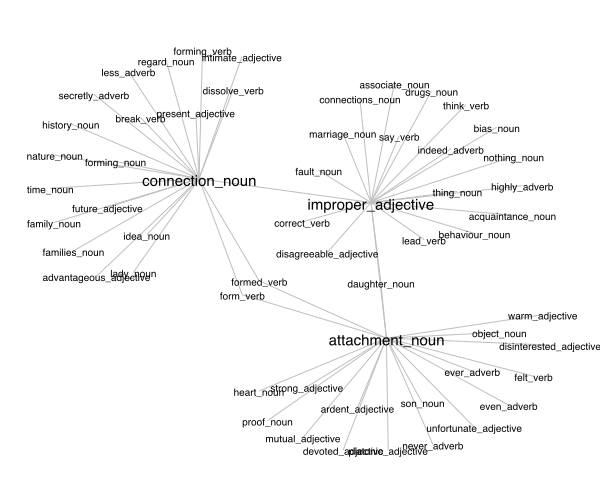

In [23]:
conn_highlights = {"connection_noun", "attachment_noun", "improper_adjective"}

vis_options = {}
vis_options["vertex_shape"] = "hidden"
vis_options["vertex_label"] = assoc_net.vs["name"]
vis_options["vertex_label_dist"] = 0
vis_options["vertex_label_size"] = [label_func(name, conn_highlights) for name in assoc_net.vs["name"]]
vis_options["bbox"] = (0, 0, 600, 500)
vis_options["margin"] = 50
vis_options["edge_color"] = "grey"
vis_options["layout"] = "kk"
ig.drawing.plot(assoc_net, "figures/figure_3_1.svg", **vis_options)
ig.drawing.plot(assoc_net, **vis_options)